In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
dataloader = DataLoader(train_dataset, batch_size = 128, shuffle = True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.66MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 220kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.06MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 459kB/s]


In [3]:
latent_dim = 100  # size of the noise vector

# Generator: takes noise -> outputs 28x28 image
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        return img.view(z.size(0), 1, 28, 28)

# Discriminator: takes image -> outputs real/fake probability
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img):
        return self.model(img.view(img.size(0), -1))


# Initialize models and optimizers

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [5]:
epochs = 20

for epoch in range(epochs):
    for real_imgs, _ in dataloader:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        # Labels: real=1, fake=0
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), real_labels)  # want D to think fakes are real
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{epochs}]  D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")


Epoch [1/20]  D loss: 0.0843, G loss: 3.0950
Epoch [2/20]  D loss: 0.1510, G loss: 5.0996
Epoch [3/20]  D loss: 0.3573, G loss: 3.9971
Epoch [4/20]  D loss: 0.3384, G loss: 2.9750
Epoch [5/20]  D loss: 1.1300, G loss: 1.7470
Epoch [6/20]  D loss: 1.8834, G loss: 0.8584
Epoch [7/20]  D loss: 0.6523, G loss: 2.1445
Epoch [8/20]  D loss: 1.3737, G loss: 0.9901
Epoch [9/20]  D loss: 0.6270, G loss: 1.5186
Epoch [10/20]  D loss: 0.2949, G loss: 2.8619
Epoch [11/20]  D loss: 0.5013, G loss: 2.1802
Epoch [12/20]  D loss: 0.9605, G loss: 2.0008
Epoch [13/20]  D loss: 0.5740, G loss: 2.1539
Epoch [14/20]  D loss: 0.4395, G loss: 3.0394
Epoch [15/20]  D loss: 0.4431, G loss: 2.2505
Epoch [16/20]  D loss: 0.8926, G loss: 2.0797
Epoch [17/20]  D loss: 0.1299, G loss: 2.4915
Epoch [18/20]  D loss: 0.9151, G loss: 2.8915
Epoch [19/20]  D loss: 0.3351, G loss: 5.5541
Epoch [20/20]  D loss: 0.1744, G loss: 4.5479


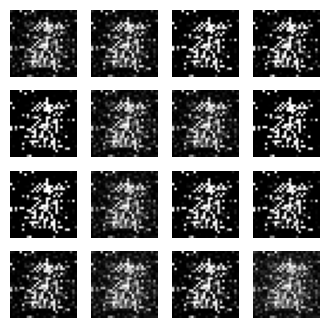

In [6]:
# After training
z = torch.randn(16, latent_dim).to(device)
gen_imgs = generator(z).cpu().detach()

plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(gen_imgs[i][0], cmap="gray")
    plt.axis("off")
plt.show()
